# A short example of how to use functional principal component analysis

## Author
Daniel Perdices <daniel.perdices at uam.es>

## Imports

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; 
import seaborn as sns
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans as km
from sklearn.metrics import silhouette_score
from typing import Callable
from matplotlib import rc

# fda is in .. 
import sys
sys.path.insert(1, "..")

import fda
plt.style.use('ggplot')

## Generating the data

In [2]:
X = np.linspace(0,1,150) # time grid
N = 360 # number of curves

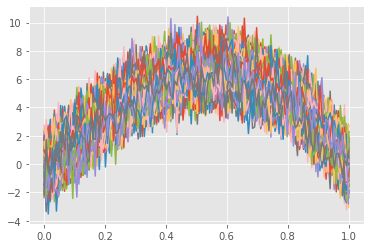

In [3]:
firstC = (30*(1-X)*np.power(X, 1.2))
firstC = fda.FData(firstC, X)
k1 = lambda s,t: 0.2 * np.exp(-np.abs(s-t) / 0.3)
firstC.plt()
GP1 = fda.GaussianProcess(firstC, k1)
samples1 = GP1.generateSamples(N)
[c.plt() for c in samples1];

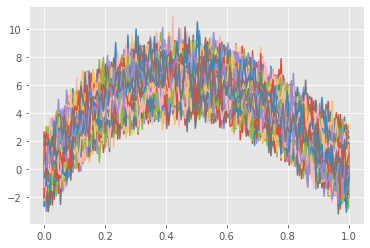

In [4]:
secondC = (np.asarray(30*X*np.power((1-X), 1.2)))
secondC = fda.FData(secondC, X)
secondC.plt()
GP2 = fda.GaussianProcess(secondC, k1)
samples2 = GP2.generateSamples(N)
[c.plt() for c in samples2];

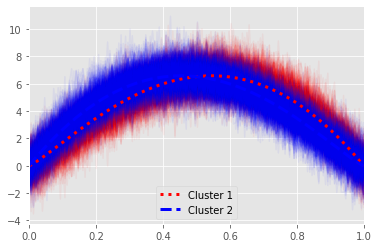

In [5]:
from scipy.stats import bernoulli
classes = bernoulli.rvs(0.5, size=N)
curves = [f if theta == 1 else g for theta, f, g in zip(classes, samples1, samples2)]
[c.plt(color="red", alpha=0.05) for c in samples1] + [c.plt(color="blue", alpha=0.05) for c in samples2];
ln1 = GP1.mean.plt(color="red", linestyle=":", linewidth=3)
ln2 = GP2.mean.plt(color="blue", linestyle="--", linewidth=3)
plt.legend([ln1[0], ln2[0]], ["Cluster 1", "Cluster 2"]);
plt.xlim([0,1]);
plt.grid(True)


In [6]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

train, test = train_test_split(curves, test_size=0.25)

## FPCA

Text(0.5, 1.0, 'Eigenfunctions')

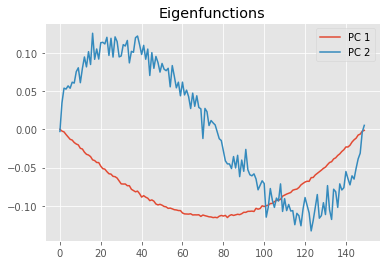

In [7]:
k = 2
fpca = fda.FPCA(k=k)
eigenvals, eigenfs = fpca.fit(train)
[f.plt() for f in eigenfs[:k]]
plt.legend([f"PC {i}" for i in range(1,k+1)])
plt.title("Eigenfunctions")

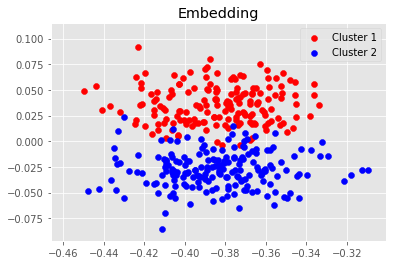

In [8]:
vals, projected = fpca.transform(curves)
plt.scatter(vals[classes==0,0], vals[classes==0,1], color="r")
plt.scatter(vals[classes==1,0], vals[classes==1,1], color="b")
plt.legend(["Cluster 1", "Cluster 2"])
plt.title("Embedding");

Text(0.5, 1.0, 'Projected curves')

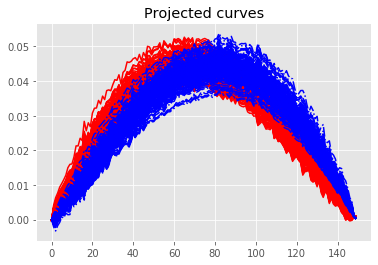

In [9]:
[f.plt(color="r") for i, f in enumerate(projected) if classes[i] == 0];
[f.plt(color="b", linestyle="-.") for i, f in enumerate(projected) if classes[i] == 1];
plt.title("Projected curves")

### Solve the classification problem in the embedding

In [10]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(vals)

-0.4496278336757894 -0.30944911729246394


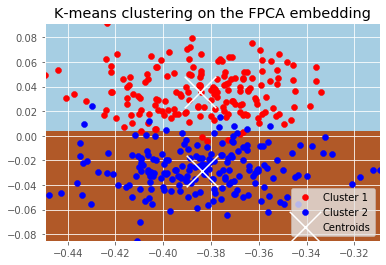

In [11]:
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10)
kmeans.fit(vals)

h = .002  
x_min, x_max = vals[:, 0].min(), vals[:, 0].max()
y_min, y_max = vals[:, 1].min(), vals[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
print(x_min, x_max)
# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.scatter(vals[classes==0,0], vals[classes==0,1], color="r")
plt.scatter(vals[classes==1,0], vals[classes==1,1], color="b")
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', linewidths=200, s=1000,
            color='w', zorder=10)
plt.title('K-means clustering on the FPCA embedding')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(["Cluster 1", "Cluster 2", "Centroids"])
plt.show()